<a href="https://colab.research.google.com/github/Mikful/Audio-Classification/blob/master/fastai_audio_Project_1_Bird_Audio_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Update Fast AI**

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Upload data and unzip into Colab for efficiency

Example : To unzip sample.zip which is in the folder Sample, run: 

`!unzip -qq '/content/gdrive/My Drive/Sample/sample'`

In [0]:
!unzip -qq "/content/drive/My Drive/Machine_Learning/My_Projects/19006 - Birds of Quinchaue Audio Classifier/Birds_of_Quinchaue_Audio_134_Species.zip"

# Setup Fast.ai Audio

**Download Github repo**

This only needs to be done once (I think - may need to check when reopening that repo is there)

In [5]:
#Setup without google drive access
  # Create folder for repo
  # Change directory to new folder
  # Name data folder
  # Clone github repo into folder
  
#!mkdir /fastai_audio
%cd /content
data_folder = 'data'
!git clone https://github.com/mogwai/fastai_audio.git 


/content
fatal: destination path 'fastai_audio' already exists and is not an empty directory.


In [6]:
 # Change directory to new fastai_audio folder
  # Pull repo
  # Install repo dependencies

%cd /content/fastai_audio
!git pull
!bash install.sh 

/content/fastai_audio
Already up to date.
     |████████████████████████████████| 81kB 7.1MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=e874ca78d0e220c2b749da9bd6d4b46291e0b940f237d76eb7b80beb6e5305dd
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packag

**Now import newly installed PyTorch Audio!:**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import sys
import csv
import shutil
from pathlib import Path
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

In [0]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

from audio import *

# AudioItem
Here we create an AudioItem to load an audio file and listen to it by passing the filename (either str or PosixPath) to AudioItem.open(), we can also see some information about the audio.

First, define the path to the data:

In [19]:
data_folder = "/content/content/Birds_of_Quinchaue_Audio_134_Species"
data_folder

'/content/content/Birds_of_Quinchaue_Audio_134_Species'

# Introduction

In this notebook we will use the library on our first real world dataset to create a model that can identify a broad range of sounds (50 classes including pigs, wind, clapping, chainsaws...etc).


## Data Leakage in Audio

When working with audio, you have to be especially careful not to leak data between your training, validation and test sets. For instance, in ESC-50, some of the clips are generated by splitting up files into several shorter clips (e.g. taking 15 seconds of guitar, and splitting it into three 5 second clips). If those files aren't kept together in one fold, and some end up in training and others in the validation set, our model may learn features we aren't interested in, like background noise, or something particular to the microphone that was used, to identify the label. 

Another example is speaker identification. If you have users record their voices on their own devices and then train a model, it may learn to identify the quirks of their microphone, or their environment, rather than the unique features of their voice. Thus you might have a model with 99.8% accuracy, but when you test it by using input from one device for all speakers, it may fail to generalize. 

In this case the data is split into 5 folds, and any clips that have been split up from one longer original are all together in the same fold. This strict segregation of data will also allow us to compare results to others knowing that we are all using the same validation set. 

## Step 1: Data Pre-Processing

https://github.com/mogwai/fastai_audio/blob/5bb4a38517263a1d117f20948fb0c86d4809ee94/00_Getting_Started.ipynb

In [0]:
config_all= AudioConfig(remove_silence = "all", silence_padding=1000, silence_threshold=20)
audios = (AudioList
             .from_folder(data_folder, config=config_all)
             .split_none()
             .label_from_folder())

Preprocessing: Removing Silence


Audio with outer and middle silence removed:
File: /root/.fastai/cache/sh-a_20-1000/Plain-breastedHawk_11331.mp3-f0ffeefcadd0ee144ea3763727a0d81b/0.wav
Total Length: 2.35 seconds
Number of Channels: 1


Channel 0.0 (128x406):


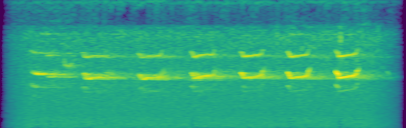

In [0]:
print("Audio with outer and middle silence removed:")
audios.train[0][0].show()

## Step 1: Training

First we set our spectrogram config. Most of the values below are defaults but given here to show the setup. Since the data needs cleaning, we need to set the silence removal, downmixing to mono, almost nothing for our `AudioConfig`, just caching and passing in the `SpectrogramConfig`

**Options for silence removal are:**

trim will remove any leading and trailing silence.
split will split the clip into multiple clips at points of silence, removing most of the silence but leaving a bit of padding to keep it smooth.
all will return the same info as split but in a single clip, all concatenated together.

In [0]:
sg_cfg= SpectrogramConfig(hop=512, n_mels=128, n_fft=1024, top_db=80, f_min=20, f_max=22050)
config = AudioConfig(sg_cfg=sg_cfg,
                     use_spectro=True,
                     duration=5000,
                     pad_mode="zeros",
                     cache=True,
                     remove_silence = "trim",
                     resample_to=16000,
                     downmix=True)

Next we load up an AudioList with our data, using `split_by_files` to separate valid and training. We don't do any transforms because we will be using mixup, which is made incredibly easy by fastai and works very well for acoustic scene classification.

In my (brief) experience, SpecAugment (putting bars over the spectrogram to hide info as a form of data augmentation) works better for speech data, and has little impact for scenes, but you should experiment further with this and normal fastai image transforms. Most image transforms don't make sense for spectrograms, but some people in our audio thread have reported small gains by using a few limited transforms.


In [26]:
#num_workers = 1 for reproducibility, see https://docs.fast.ai/dev/test.html#getting-reproducible-results
#tfms = get_spectro_transforms(mask_frequency=False, mask_time=False, size=(256,430))
tfms=None
audios = (AudioList
            .from_folder(data_folder, config=config)
            .split_subsets(train_size=0.2, valid_size=0.05, seed=4)  # split dataset into subsets for quicker training
            .label_from_folder()
            .databunch(bs=16, num_workers = 1))#(is_reg=False)


Preprocessing: Downmixing to Mono


Preprocessing: Resampling to 16000


Preprocessing: Removing Silence


Preprocessing: Downmixing to Mono


Preprocessing: Resampling to 16000


Preprocessing: Removing Silence


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Rufous-breasted_Chat-tyrant, Barred Becard, Paramo Seedeater, American Kestrel
  if getattr(ds, 'warn', False): warn(ds.warn)


In [0]:
audios.save('/content/drive/My Drive/Machine_Learning/My_Projects/fast.ai-Audio-Project-1-Colombian-Bird-Call-Recognition/data_subset_save.pkl')

In [27]:
audios.train_ds[0][0].shape

torch.Size([1, 128, 156])

------------------------------------------------------------
File: /root/.fastai/cache/sh-t_20-200/0.wav-40dfb7f7f81338585653a1379515cf6a/0.wav
Total Length: 51.72 seconds
Number of Channels: 1
Label: Russet-backed Oropendola
24.9s-29.9s of original clip


Channel 0.0 (128x156):


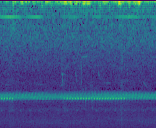

------------------------------------------------------------
File: /root/.fastai/cache/sh-t_20-200/0.wav-5ae44f721806a304e9fbd12448528fc5/0.wav
Total Length: 37.2 seconds
Number of Channels: 1
Label: House Wren
3.17s-8.17s of original clip


Channel 0.0 (128x156):


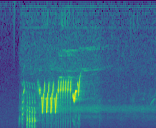

------------------------------------------------------------
File: /root/.fastai/cache/sh-t_20-200/0.wav-d583ca0d05e774a7ff5c55ba87b5075f/0.wav
Total Length: 3.98 seconds
Number of Channels: 1
Label: Black-crested Warbler


Channel 0.0 (128x156):


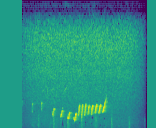

In [28]:
audios.show_batch()

When using mixup on audio, I've found much better results using densenets (121 and 161) but this is without having done a comprehensive search of the available architectures. More work is needed here from the community. Resnets up to resnet50 don't seem to be deep enough as training loss is always higher than validation (I haven't tried lowering other forms of regularization to reduce this)

In [21]:
learn = cnn_learner(audios, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True)#.mixup()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 89.7MB/s]


In [22]:
learn.lr_find(); learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
learn.fit_one_cycle(100, slice(1e-2))

RuntimeError: ignored

In [0]:
learn.save('ESC50-stage1')

In [0]:
learn.export(PATH_DATA/'models/895peakacc-stg1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

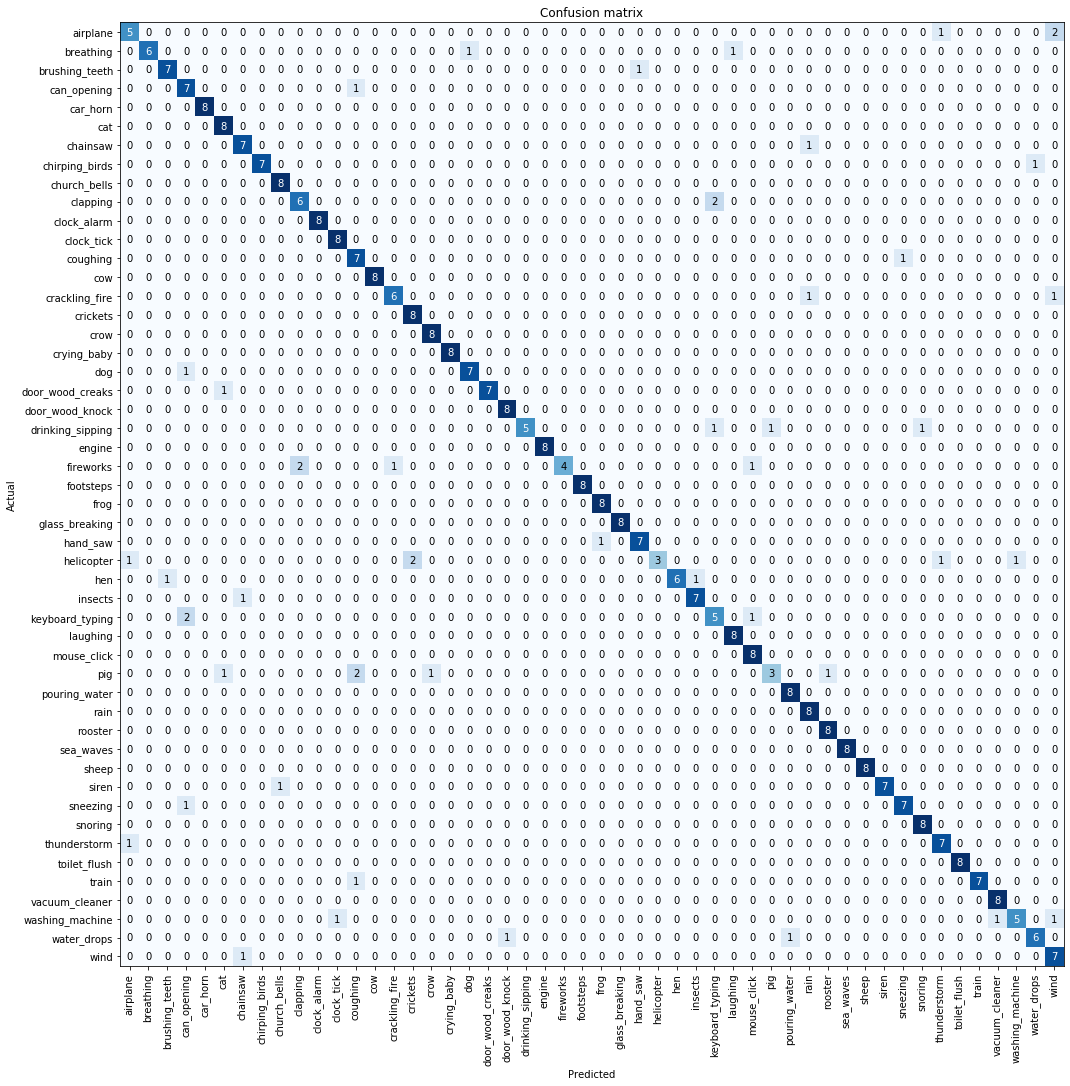

In [0]:
interp.plot_confusion_matrix(figsize=(15,15))

For a closer look at our most frequently confused classes, we can call the aptly named `most_confused` function. All of these seem like classes that could be hard to differentiate, so we are on the right track. 

In [0]:
interp.most_confused(min_val=2)

[('airplane', 'wind', 2),
 ('clapping', 'keyboard_typing', 2),
 ('fireworks', 'clapping', 2),
 ('helicopter', 'crickets', 2),
 ('keyboard_typing', 'can_opening', 2),
 ('pig', 'coughing', 2)]

We can call `plot_top_losses` to both see and hear the clips that are fooling our model. If you listen it becomes clear just how hard some of these are to distinguish. Others seem like something the model shouldn't be getting wrong, and are a good place to start trying to look for ways to improve the model. 

File: ../data/ESC-50/ESC-50-master/audio/5-103420-A-2.wav
Total Length: 5.0 seconds
Label: cat/pig / 6.16 / 0.00


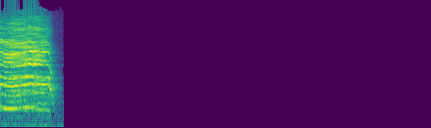

File: ../data/ESC-50/ESC-50-master/audio/5-103416-A-2.wav
Total Length: 5.0 seconds
Label: rooster/pig / 4.98 / 0.01


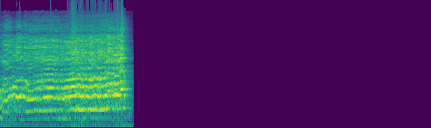

File: ../data/ESC-50/ESC-50-master/audio/5-233787-A-7.wav
Total Length: 5.0 seconds
Label: chainsaw/insects / 4.30 / 0.01


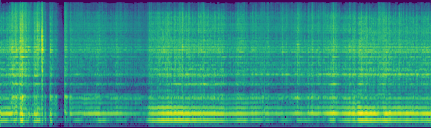

File: ../data/ESC-50/ESC-50-master/audio/5-220955-A-40.wav
Total Length: 5.0 seconds
Label: thunderstorm/helicopter / 4.04 / 0.02


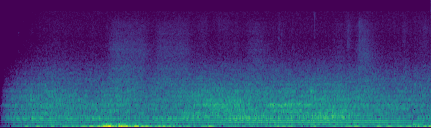

File: ../data/ESC-50/ESC-50-master/audio/5-223099-A-32.wav
Total Length: 5.0 seconds
Label: can_opening/keyboard_typing / 3.97 / 0.02


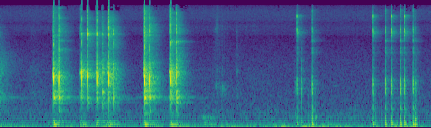

File: ../data/ESC-50/ESC-50-master/audio/5-207836-A-29.wav
Total Length: 5.0 seconds
Label: pig/drinking_sipping / 3.91 / 0.02


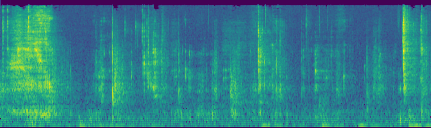

File: ../data/ESC-50/ESC-50-master/audio/5-181977-A-35.wav
Total Length: 5.0 seconds
Label: clock_tick/washing_machine / 3.87 / 0.02


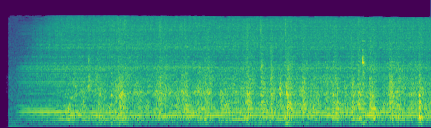

File: ../data/ESC-50/ESC-50-master/audio/5-204114-A-29.wav
Total Length: 5.0 seconds
Label: keyboard_typing/drinking_sipping / 3.78 / 0.02


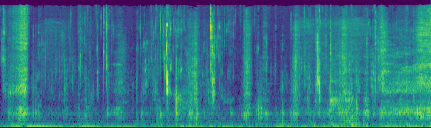

File: ../data/ESC-50/ESC-50-master/audio/5-205090-A-32.wav
Total Length: 5.0 seconds
Label: mouse_click/keyboard_typing / 3.68 / 0.03


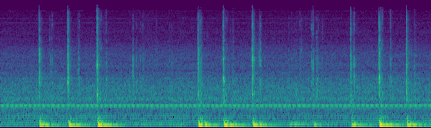

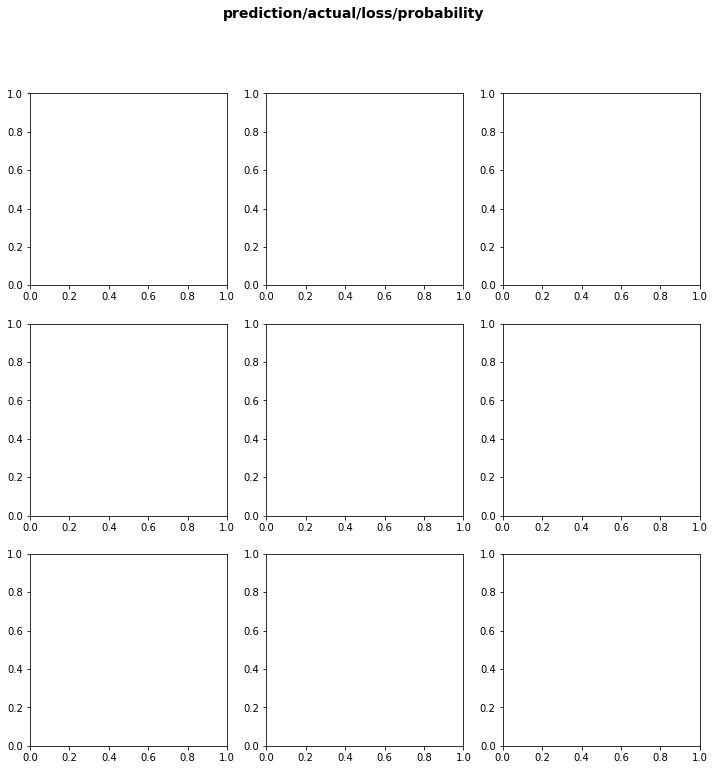

In [0]:
interp.plot_top_losses(9, heatmap=False)

## Step 2: Training on all folds

Because we have limited data, it is best practice to repeat the process cycling the validation fold to make sure we aren't just overfitting that one fold, we will repeat the process cycling the validation fold. For the sake of time, and because I clearly haven't figured out how to fine-tune mixup yet, and unfreeze/layer_groups might not be working on our learner, we will just do 100 epochs at 1e-2.

**Side note**: Sometimes you'll see this referred to as "k-folds validation" in kaggle competitions. The idea is that you split your data up into k (usually 5 or 10) different folds and then train models cycling the training/validation sets. The point is that by doing this on 5 folds, you'll have 5 different models that can then be used to perform inference, ensembling the various predictions. The cost is high though as you will increase your training time by 5x for a small gain. I also don't fully understand why this is better than just using 100% of your data and no validation once you have a training method you've already validated. If you can explain why, please post in the audio thread and I'll update/credit you here. 

In [0]:
results = []
fold_5_result = learn.validate()
results.append(fold_5_result)
results

[[0.52252144, tensor(0.8750)]]

In [0]:
#it is range(1,5), not range(1,6) because we already used fold 5 as validation fold
for VAL_FOLD in range(1,5):
    FILES_TRAIN = [f for f in DF.loc[DF['fold'] != VAL_FOLD].filename]
    FILES_TEST = [f for f in DF.loc[DF['fold'] == VAL_FOLD].filename]
    audio_train = AudioList.from_csv(PATH_AUDIO, PATH_CSV, config=cfg).split_by_files(FILES_TEST).label_from_df("category")
    db_audio = audio_train.transform(tfms=None).databunch(bs=16, num_workers=1)
    learn = cnn_learner(db_audio, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()
    learn.fit_one_cycle(100, slice(1e-2))
    results.append(learn.validate())
    print(results)

[[0.48709515, tensor(0.8850)], [0.51108325, tensor(0.8850)], [0.56737393, tensor(0.8625)], [0.90310854, tensor(0.9075)], [0.56284475, tensor(0.9025)]]


In [0]:
results

[[0.48709515, tensor(0.8850)],
 [0.51108325, tensor(0.8850)],
 [0.56737393, tensor(0.8625)],
 [0.90310854, tensor(0.9075)],
 [0.56284475, tensor(0.9025)]]

In [0]:
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [0]:
average_validation = sum([score for _, score in results])/5

In [0]:
average_validation

tensor(0.8885)

Note, the first time I ran this it produced the numbers above, but on loading the exported model and revalidating, it's accuracy on fold 5 was .8750, which would bring the overall average validation down to 0.8865